<a href="https://colab.research.google.com/github/ykt345/temp/blob/master/201005_Tutrial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

このTutrialは[こちら](https://colab.research.google.com/drive/1gCgtlnMPVWY0l1ra8ssS0EzJiWaVR4Pk#scrollTo=uF1P_cRoWpvM)を弊社で利用する用に変更したり、説明を加えたりしたものです。

# 下準備
*   PyTorch(機械学習ライブラリ)をインストールします。<br>
※現在の最新のPyTorch version = 1.6.xですが、ライブラリ間を考慮して1.2.0を利用します。
*   必要に応じてランタイムのタイプを変更します。

In [ ]:
!pip3 install torch==1.2.0+cu92 torchvision==0.4.0+cu92 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

In [ ]:
print(torch.__version__)

1.2.0+cu92


# 学習・テストデータをダウンロード
今回は手書き文字のデータセットである[MNIST](http://yann.lecun.com/exdb/mnist/)を利用します。データはダウンロード、インポートするだけでなく整形も行います。</br>

*   データをテンソルに変換するために `transforms` モジュールを使います。
*   便利なデータローダやイテレータと呼ばれるものを構築するために `DataLoader` を利用します。</br>
*   データローダの中で `batch` パラメータを設定することでデータのバッチを作成します。このチュートリアルでは `32` のバッチを使用していますが、お好みであれば `64` に変更しても構いません。いろいろなバッチを試してみることをお勧めします。
*   データローダはデータセットからデータをバッチサイズに固めて返すモジュールです。
*   イテレータは反復可能オブジェクトです。詳しくは[こちら](https://www.atmarkit.co.jp/ait/articles/1906/11/news007_2.html#whatsiterator)を読んでください。



In [ ]:
BATCH_SIZE = 32

## transformations
transform = transforms.Compose(
    [transforms.ToTensor()])

## download and load training dataset
trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

## download and load testing dataset
testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

  0%|          | 16384/9912422 [00:00<01:18, 126207.96it/s]

9920512it [00:00, 25806286.32it/s]                           


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


32768it [00:00, 374458.37it/s]
0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


1654784it [00:00, 8747894.72it/s]                          
  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


8192it [00:00, 58105.66it/s]            


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


# データの中身を確認する


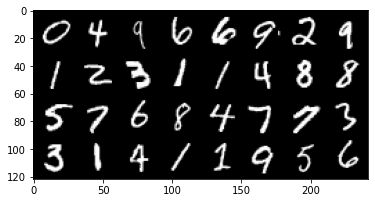

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

## functions to show an image
def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

## get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

## show images
imshow(torchvision.utils.make_grid(images))

バッチの次元を確認します。

*     `shape`はテンソルを見える化してくれます。 `x.size()` でも同じ結果を出せます。





In [ ]:
for images, labels in trainloader:
    print("Image batch dimensions:", images.shape)
    print("Image label dimensions:", labels.shape)
    break

Image batch dimensions: torch.Size([32, 1, 28, 28])
Image label dimensions: torch.Size([32])


# モデルを作成


*   モデルは `__init__()` の部分で構成されており、ニューラルネットワークのレイヤーとコンポーネントを含んでいます。このモデルでは、`nn.Conv2d(....)`という畳み込み層があります。グレースケールの画像データセットを扱っているので、入力するチャンネルは1つだけ必要となり` in_channels=1 ` となります。この層をきれいに表現したいので，`out_channels=32` を利用します。カーネルサイズは3で、その他のパラメータはライブラリのデフォルト値を使用します。
*   `d1` には、どこからともなく出てきたような次元があることに注目してください。128は出力したいサイズを表し、(`26*26*32`)は入力データの次元を表します。これらの計算方法については [PyTorch documentation](https://pytorch.org/docs/stable/nn.html?highlight=linear#conv2d) を参照してください。要するに、畳み込み層は入力データを線形層で考慮しなければならない特定の次元に変換します。2回目の線形変換 (`d2`) も同様で、前の線形層の出力の次元を `in_features=128` とし、`10` は出力のサイズで、クラスの数にも対応しています。
*   これらの各層の後には、`ReLU`のような活性化関数も適用します。
*   予測のために，最後の変換に `softmax` のレイヤを適用し，その出力を返します。



In [ ]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()

        # 28x28x1 => 26x26x32
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
        self.d1 = nn.Linear(26 * 26 * 32, 128)
        self.d2 = nn.Linear(128, 10)

    def forward(self, x):
        # 32x1x28x28 => 32x32x26x26
        x = self.conv1(x)
        x = F.relu(x)

        # flatten => 32 x (32*26*26)
        x = x.flatten(start_dim = 1)

        # 32 x (32*26*26) => 32x128
        x = self.d1(x)
        x = F.relu(x)

        # logits => 32x10
        logits = self.d2(x)
        out = F.softmax(logits, dim=1)
        return out

次元が望むものになっているかどうかを確認します。

In [ ]:
## test the model with 1 batch
model = MyModel()
for images, labels in trainloader:
    print("batch size:", images.shape)
    out = model(images)
    print(out.shape)
    break

batch size: torch.Size([32, 1, 28, 28])
torch.Size([32, 10])


# 学習
これでモデルを訓練する準備ができましたが、その前にloss、optimizer、モデルの精度を計算する関数を設定します。


*   lossとは
*   optimaizerとは



In [ ]:
learning_rate = 0.001
num_epochs = 5

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = MyModel()
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
## compute accuracy
def get_accuracy(logit, target, batch_size):
    ''' Obtain accuracy for training round '''
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects/batch_size
    print = accuracy
    return accuracy.item()

学習します。

In [ ]:
for epoch in range(num_epochs):
    train_running_loss = 0.0
    train_acc = 0.0

    model = model.train()

    ## training step
    for i, (images, labels) in enumerate(trainloader):
        
        images = images.to(device)
        labels = labels.to(device)

        ## forward + backprop + loss
        logits = model(images)
        loss = criterion(logits, labels)
        optimizer.zero_grad()
        loss.backward()

        ## update model params
        optimizer.step()

        train_running_loss += loss.detach().item()
        train_acc += get_accuracy(logits, labels, BATCH_SIZE)
    
    model.eval()
    print('Epoch: %d | Loss: %.4f | Train Accuracy: %.2f' \
          %(epoch, train_running_loss / i, train_acc/i))   

Epoch: 0 | Loss: 1.5775 | Train Accuracy: 88.24
Epoch: 1 | Loss: 1.4936 | Train Accuracy: 96.54
Epoch: 2 | Loss: 1.4834 | Train Accuracy: 97.61
Epoch: 3 | Loss: 1.4780 | Train Accuracy: 98.16
Epoch: 4 | Loss: 1.4752 | Train Accuracy: 98.49


In [ ]:
plt.plot(np.arange(len(losses_train)), losses_train, label= "train")
plt.plot(np.arange(len(losses_val)), losses_val, label= "val")
plt.xlabel("epoch")
plt.legend()
plt.show()

テストします。

In [ ]:
test_acc = 0.0
for i, (images, labels) in enumerate(testloader, 0):
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    test_acc += get_accuracy(outputs, labels, BATCH_SIZE)
        
print('Test Accuracy: %.2f'%( test_acc/i))

Test Accuracy: 97.71
